# **IST 736: Text Mining**

**Nikita Ramsey**

Homework #3

# Introduction:

For this assignment, I decided to use the title of all of the executive orders Joe Biden signed in January 2025 before leaving office to see if they could be grouped by commonality. I'm quite interested in the executive orders that have been signed thus far in 2025 and ultimately will want to see if there are some defining characteristics between the executive orders of Joe Biden and Donal Trump, but for now the focus is on Biden.


We'll first start by installing and loading the necessary libraries.

In [ ]:
pip install seaborn nltk pandas matplotlib contractions textblob spacy

Note: you may need to restart the kernel to use updated packages.


Loading libraries

In [ ]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

from collections import Counter
from wordcloud import WordCloud

import spacy
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# **Data:**

This data was obtained from the Federal Register website, where a csv file was downloaded that contained all of the executive orders signed by Joe Biden in 2025. The original csv file and several columns, however only the 'title' column will be used for this analysis. Below, I isolate the 'title' column then create a corpus of text files, so that every title is a row and text file in the new data frame; there are 162 rows in the available data.

Here I'm going to take a column out of my CSV file and make a corpus from it

In [ ]:
# Step 1: Load the CSV file
csv_file = 'documents_signed_by_joseph_r_biden_jr_of_type_presidential_document_and_of_presidential_document_type_executive_order.csv'  # Replace with your file path
df = pd.read_csv(csv_file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   citation                      162 non-null    object 
 1   document_number               162 non-null    object 
 2   end_page                      162 non-null    int64  
 3   html_url                      162 non-null    object 
 4   pdf_url                       162 non-null    object 
 5   type                          162 non-null    object 
 6   subtype                       162 non-null    object 
 7   publication_date              162 non-null    object 
 8   signing_date                  162 non-null    object 
 9   start_page                    162 non-null    int64  
 10  title                         162 non-null    object 
 11  disposition_notes             130 non-null    object 
 12  executive_order_number        162 non-null    int64  
 13  not_r

In [ ]:
df.head()

,citation,document_number,end_page,html_url,pdf_url,type,subtype,publication_date,signing_date,start_page,title,disposition_notes,executive_order_number,not_received_for_publication
0,90 FR 8105,2025-01758,8107,https://www.federalregister.gov/documents/2025...,https://www.govinfo.gov/content/pkg/FR-2025-01...,Presidential Document,Executive Order,1/24/2025,1/19/2025,8105,Helping Left-Behind Communities Make a Comeback,NaN,14145,NaN
1,90 FR 8109,2025-01759,8110,https://www.federalregister.gov/documents/2025...,https://www.govinfo.gov/content/pkg/FR-2025-01...,Presidential Document,Executive Order,1/24/2025,1/19/2025,8109,Partial Revocation of Executive Order 13961,NaN,14146,NaN
2,90 FR 5469,2025-01395,5489,https://www.federalregister.gov/documents/2025...,https://www.govinfo.gov/content/pkg/FR-2025-01...,Presidential Document,Executive Order,1/17/2025,1/14/2025,5469,Advancing United States Leadership in Artifici...,NaN,14141,NaN
3,90 FR 6709,2025-01437,6710,https://www.federalregister.gov/documents/2025...,https://www.govinfo.gov/content/pkg/FR-2025-01...,Presidential Document,Executive Order,1/17/2025,1/15/2025,6709,Taking Additional Steps With Respect to the Si...,NaN,14142,NaN
4,90 FR 6751,2025-01467,6753,https://www.federalregister.gov/documents/2025...,https://www.govinfo.gov/content/pkg/FR-2025-01...,Presidential Document,Executive Order,1/17/2025,1/16/2025,6751,Providing for the Appointment of Alumni of Ame...,NaN,14143,NaN


In [ ]:
column_name = 'title'  # Replace with the name of the column you want
text_data = df[column_name]
text_data.head()

0      Helping Left-Behind Communities Make a Comeback
1          Partial Revocation of Executive Order 13961
2    Advancing United States Leadership in Artifici...
3    Taking Additional Steps With Respect to the Si...
4    Providing for the Appointment of Alumni of Ame...
Name: title, dtype: object

In [ ]:
# Step 3: Create a folder for text files
output_folder = 'biden_text_corpus'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [ ]:
# Step 4: Initialize lists to store corpus, file names, and paths
corpus = []
file_names = []
file_paths = []

In [ ]:
# Step 5: Write each row to a text file and store metadata
for idx, text in text_data.items():
    # Define the file name and path
    file_name = f'doc_{idx+1}.txt'
    file_path = os.path.join(output_folder, file_name)

    # Write the text to the file
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(str(text))

    # Store metadata
    corpus.append(str(text))         # The text content for the vectorizer
    file_names.append(file_name)     # The file name
    file_paths.append(file_path)     # The complete path

In [ ]:
# Print summaries
print("Corpus created successfully!")
print("Sample text from corpus:", corpus[:2])  # Display first 2 text entries as sample
print("Sample file names:", file_names[:2])
print("Sample file paths:", file_paths[:2])

Corpus created successfully!
Sample text from corpus: ['Helping Left-Behind Communities Make a Comeback', 'Partial Revocation of Executive Order 13961']
Sample file names: ['doc_1.txt', 'doc_2.txt']
Sample file paths: ['biden_text_corpus\\doc_1.txt', 'biden_text_corpus\\doc_2.txt']


I now have my corpus loaded, so I'll create a new dataframe to begin preprocessing the data.

In [ ]:
data = pd.DataFrame({
    'file_name': file_names,  # File names
    'text': corpus         # Text content
})

# Adjust display settings
pd.set_option('display.max_colwidth', None)

# Display the results
print(f"Loaded {len(data)} text files into the corpus.")
data.head(10)

Loaded 162 text files into the corpus.


,file_name,text
0,doc_1.txt,Helping Left-Behind Communities Make a Comeback
1,doc_2.txt,Partial Revocation of Executive Order 13961
2,doc_3.txt,Advancing United States Leadership in Artificial Intelligence Infrastructure
3,doc_4.txt,Taking Additional Steps With Respect to the Situation in Syria
4,doc_5.txt,Providing for the Appointment of Alumni of AmeriCorps to the Competitive Service
5,doc_6.txt,Strengthening and Promoting Innovation in the Nation's Cybersecurity
6,doc_7.txt,Providing an Order of Succession Within the Office of the National Cyber Director
7,doc_8.txt,Providing an Order of Succession Within the Department of Agriculture
8,doc_9.txt,Providing an Order of Succession Within the Department of Homeland Security
9,doc_10.txt,Providing an Order of Succession Within the Department of Justice


**Initial preprocessing:**

To begin the preprocessing of the text, this function will be used to get the data in a clean state.

In [ ]:
import contractions

# Clean the text
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = contractions.fix(text)  # Expand contractions
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.lower().strip()  # Convert to lowercase and strip spaces

In [ ]:
# Clean the text and add to dt
data['cleaned_text'] = data['text'].apply(clean_text)

# Compare text to ensure cleaning steps were applied
data['text']

0                                                      Helping Left-Behind Communities Make a Comeback
1                                                          Partial Revocation of Executive Order 13961
2                         Advancing United States Leadership in Artificial Intelligence Infrastructure
3                                       Taking Additional Steps With Respect to the Situation in Syria
4                     Providing for the Appointment of Alumni of AmeriCorps to the Competitive Service
                                                    ...                                               
157                                                   Ethics Commitments by Executive Branch Personnel
158    Protecting Public Health and the Environment and Restoring Science To Tackle the Climate Crisis
159                                        Protecting the Federal Workforce and Requiring Mask-Wearing
160                               Revocation of Certain Executive Orders 

In [ ]:
# Display the cleaned text
data['cleaned_text']

0                                                       helping leftbehind communities make a comeback
1                                                                partial revocation of executive order
2                         advancing united states leadership in artificial intelligence infrastructure
3                                       taking additional steps with respect to the situation in syria
4                     providing for the appointment of alumni of americorps to the competitive service
                                                    ...                                               
157                                                   ethics commitments by executive branch personnel
158    protecting public health and the environment and restoring science to tackle the climate crisis
159                                         protecting the federal workforce and requiring maskwearing
160                               revocation of certain executive orders 

**Exploratory Data Analysis**

Here we'll look at the distribution of text lengths, word counts, average word lengths, and polarity, in addition to creating unigram WordClouds.

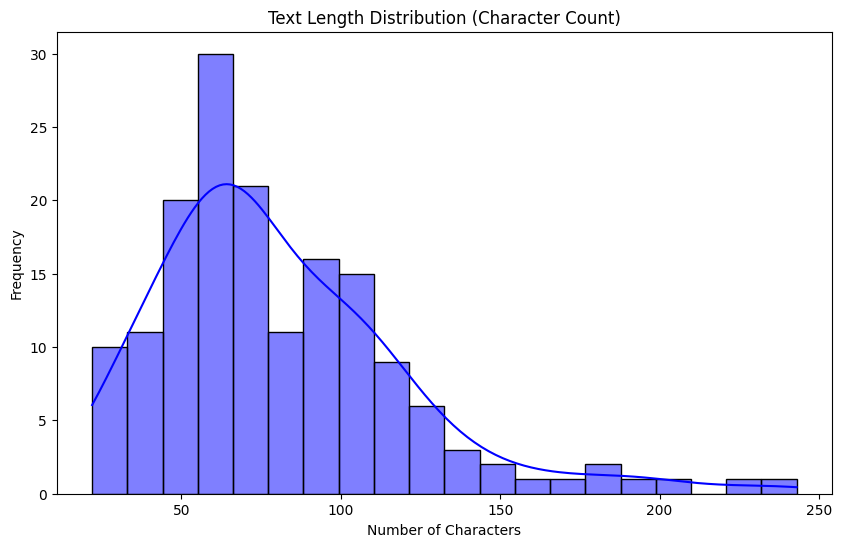

In [ ]:
### 1. Text Length Distribution (Character Count)
data['text_length'] = data['cleaned_text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=20, kde=True, color="blue")
plt.title("Text Length Distribution (Character Count)")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

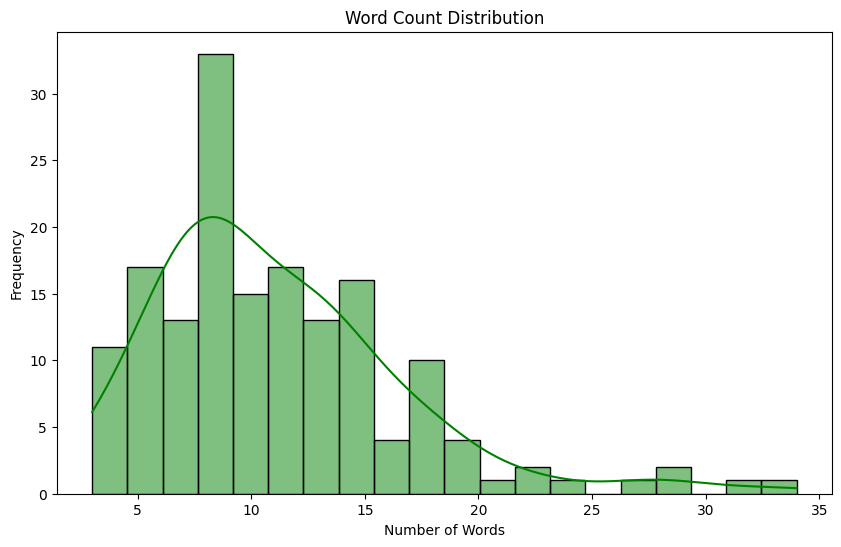

In [ ]:
### 2. Word Count Distribution
data['word_count'] = data['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(data['word_count'], bins=20, kde=True, color="green")
plt.title("Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

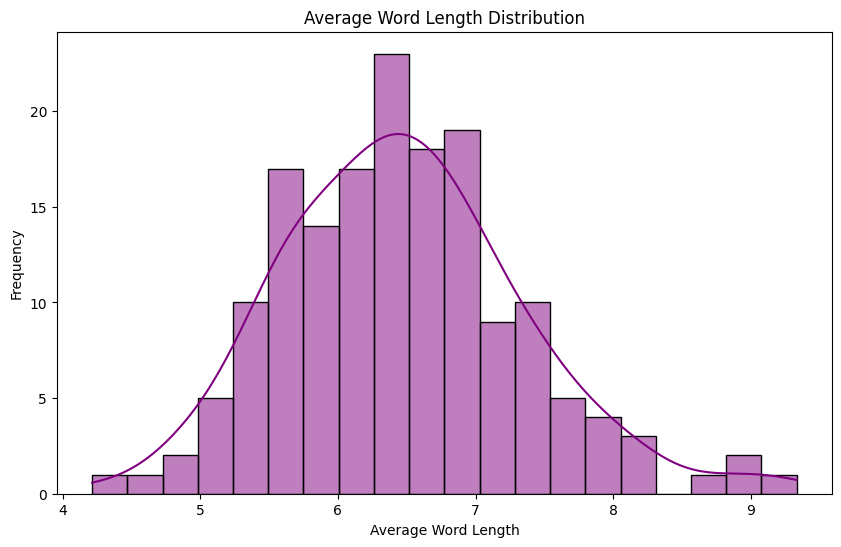

In [ ]:
### 3. Average Word Length Distribution
data['avg_word_length'] = data['cleaned_text'].apply(
    lambda x: sum(len(word) for word in x.split()) / len(x.split())
)

plt.figure(figsize=(10, 6))
sns.histplot(data['avg_word_length'], bins=20, kde=True, color="purple")
plt.title("Average Word Length Distribution")
plt.xlabel("Average Word Length")
plt.ylabel("Frequency")
plt.show()

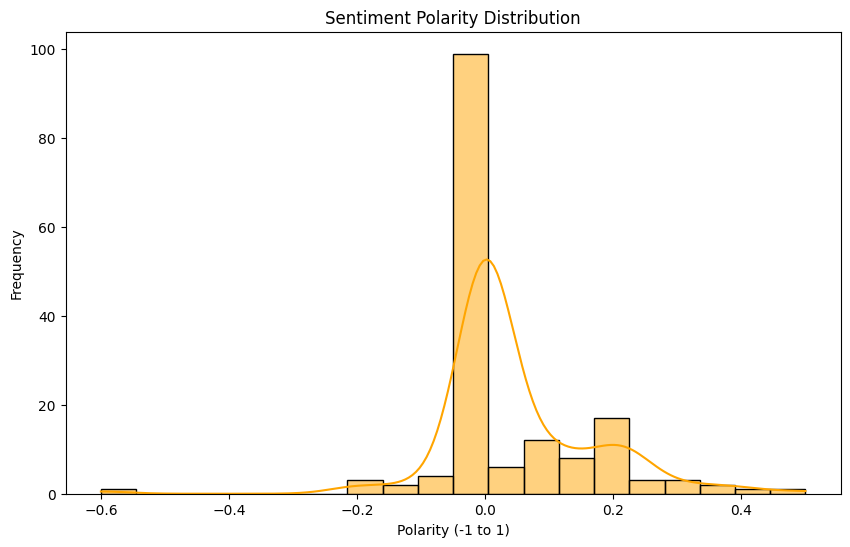

In [ ]:
### 4. Polarity Distribution
data['polarity'] = data['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 6))
sns.histplot(data['polarity'], bins=20, kde=True, color="orange")
plt.title("Sentiment Polarity Distribution")
plt.xlabel("Polarity (-1 to 1)")
plt.ylabel("Frequency")
plt.show()

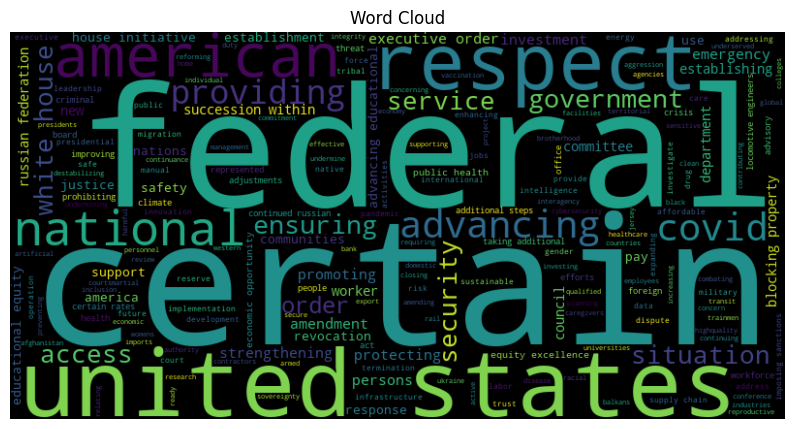

In [ ]:
### 6. Word Cloud
all_text = " ".join(data['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud")
plt.show()

In [ ]:
# Load spaCy for preprocessing
nlp = spacy.load("en_core_web_sm")

# Custom tokenizer for text preprocessing for word cloud
def preprocess_text_for_wc(text):
    doc = nlp(text.lower())
    return [token for token in doc if not token.is_stop and not token.is_punct]

In [ ]:
# Preprocess all text and calculate word frequencies
data['wc_processed_text'] = data['cleaned_text'].apply(preprocess_text_for_wc)
all_words = [str(word) for tokens in data['wc_processed_text'] for word in tokens]  # Ensure tokens are strings
word_freq = Counter(all_words)

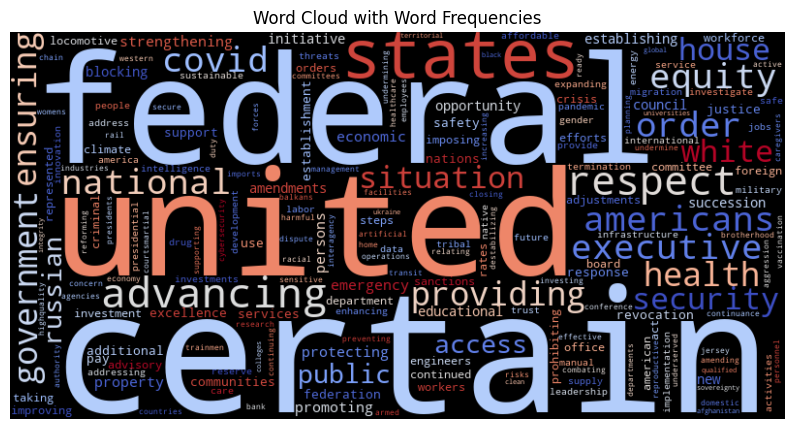

In [ ]:
# Generate WordCloud using word frequencies
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="black",
    colormap="coolwarm"
).generate_from_frequencies(word_freq)
# Visualize WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud with Word Frequencies")
plt.show()

# **Methods and Models**

To address this clustering problem, DBScan will be used to identify potential groupings that can organize the executive order titles.

**DBScan:**

DBSCAN is a method used to identify groups (or clusters) of data points that are close together while also recognizing and excluding outliers (points that don’t belong to any group).

    -For each point, DBSCAN checks how many other points are within a specified distance.
    -If enough points are found nearby, they form a cluster.
    -Points that do not have enough nearby neighbors are classified as outliers and ignored.


Unlike some clustering methods, DBSCAN can discover clusters of different shapes and sizes without requiring the user to specify the number of clusters beforehand.

**Experimental Design**

After completing EDA, we'll now lemmatize the text, then create multiple vectorizers utilizing various parameters. From there, we'll pass the vectorized text to DBScan to identify any potential groups of titles.

In [ ]:
data.head()


,file_name,text,cleaned_text,text_length,word_count,avg_word_length,polarity,wc_processed_text
0,doc_1.txt,Helping Left-Behind Communities Make a Comeback,helping leftbehind communities make a comeback,46,6,6.833333,0.0,"[helping, leftbehind, communities, comeback]"
1,doc_2.txt,Partial Revocation of Executive Order 13961,partial revocation of executive order,37,5,6.600000,-0.1,"[partial, revocation, executive, order]"
2,doc_3.txt,Advancing United States Leadership in Artificial Intelligence Infrastructure,advancing united states leadership in artificial intelligence infrastructure,76,8,8.625000,-0.6,"[advancing, united, states, leadership, artificial, intelligence, infrastructure]"
3,doc_4.txt,Taking Additional Steps With Respect to the Situation in Syria,taking additional steps with respect to the situation in syria,62,10,5.300000,0.0,"[taking, additional, steps, respect, situation, syria]"
4,doc_5.txt,Providing for the Appointment of Alumni of AmeriCorps to the Competitive Service,providing for the appointment of alumni of americorps to the competitive service,80,12,5.750000,0.0,"[providing, appointment, alumni, americorps, competitive, service]"


In [ ]:
# Function to preprocess text: lemmatize
def preprocess(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [ ]:
data['lemmatized_text'] = data['cleaned_text'].apply(preprocess)

In [ ]:
# Compare the lemmatized and cleaned text to ensure application
data['cleaned_text'].head()

0                                      helping leftbehind communities make a comeback
1                                               partial revocation of executive order
2        advancing united states leadership in artificial intelligence infrastructure
3                      taking additional steps with respect to the situation in syria
4    providing for the appointment of alumni of americorps to the competitive service
Name: cleaned_text, dtype: object

In [ ]:
data['lemmatized_text'].head()

0                                         help leftbehind community make a comeback
1                                             partial revocation of executive order
2        advance united states leadership in artificial intelligence infrastructure
3                       take additional step with respect to the situation in syria
4    provide for the appointment of alumnus of americorp to the competitive service
Name: lemmatized_text, dtype: object

In [ ]:
# Review stop words
stops =list(set(ENGLISH_STOP_WORDS))
stops

['above',
 'inc',
 'been',
 'here',
 'about',
 'thence',
 'this',
 'bill',
 'towards',
 'ourselves',
 'made',
 'next',
 'twenty',
 'someone',
 'amount',
 'again',
 'so',
 'every',
 'give',
 'become',
 'then',
 'when',
 'cant',
 'seems',
 'whereupon',
 'sixty',
 'on',
 'somewhere',
 'few',
 'me',
 'only',
 'rather',
 'please',
 'within',
 'between',
 'thru',
 'yourselves',
 'her',
 'else',
 'see',
 'several',
 'nobody',
 'seeming',
 'than',
 'name',
 'those',
 'toward',
 'namely',
 'nothing',
 'which',
 'out',
 'whole',
 'behind',
 'during',
 'along',
 'whereby',
 'hereafter',
 'they',
 'has',
 'con',
 'do',
 'nowhere',
 'beforehand',
 'no',
 'more',
 'hence',
 'even',
 'up',
 'cry',
 'call',
 'your',
 'done',
 'his',
 'yours',
 'itself',
 'whence',
 'own',
 'have',
 'per',
 'seemed',
 'fifty',
 'all',
 'perhaps',
 'un',
 'whether',
 'becoming',
 'from',
 'many',
 'with',
 'put',
 'wherein',
 'get',
 'go',
 'de',
 'will',
 'without',
 'eight',
 'ever',
 'after',
 'sometime',
 'whenever'

Initialize vectorizers:

Here I'll be trying out 3 different experimental designs in regards to the vectorizers. I'll be using both the CountVectorizer and the TfidfVectorizer. The first implementation will be the countvectorizer with max_features set to 50, the second implementation will use the TFIDFVectorizer with stop words removed and max_features set to 50, and the final implementation will be identical to the second, except the max_features will be set to 20.

In [ ]:
# base vectorizer w/o any additional parameters set
base_count_vectorizer = CountVectorizer(max_features=50)

base_count = base_count_vectorizer.fit_transform(data['lemmatized_text'])

base_count_vectorizer.get_feature_names_out()

array(['access', 'address', 'advance', 'amendment', 'americans', 'an',
       'and', 'block', 'by', 'certain', 'covid', 'economic',
       'educational', 'emergency', 'ensure', 'equity', 'executive',
       'federal', 'federation', 'for', 'government', 'health', 'house',
       'in', 'initiative', 'investment', 'national', 'of', 'on', 'order',
       'person', 'promote', 'property', 'protect', 'provide', 'public',
       'respect', 'russian', 'security', 'service', 'situation', 'states',
       'strengthen', 'succession', 'support', 'the', 'to', 'united',
       'white', 'with'], dtype=object)

In [ ]:
# base vectorizer w/ words lowercased and stopwords removed
stops_tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words=stops, max_features=50)

stops_tfidf = stops_tfidf_vectorizer.fit_transform(data['lemmatized_text'])

stops_tfidf_vectorizer.get_feature_names_out()

array(['access', 'address', 'advance', 'amendment', 'american',
       'americans', 'block', 'certain', 'committee', 'community',
       'continue', 'council', 'covid', 'department', 'economic',
       'educational', 'emergency', 'ensure', 'equity', 'establish',
       'executive', 'federal', 'federation', 'government', 'health',
       'house', 'initiative', 'investment', 'national', 'new',
       'opportunity', 'order', 'person', 'promote', 'property', 'protect',
       'provide', 'public', 'respect', 'russian', 'security', 'service',
       'situation', 'states', 'strengthen', 'succession', 'support',
       'united', 'white', 'worker'], dtype=object)

In [ ]:
# base vectorizer w/ lowercased, stopwords removed, lemmatized, max features = 100
max_features_tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words=stops, max_features=25)

max_features_tfidf = max_features_tfidf_vectorizer.fit_transform(data['lemmatized_text'])

max_features_tfidf_vectorizer.get_feature_names_out()

array(['access', 'advance', 'certain', 'covid', 'ensure', 'equity',
       'executive', 'federal', 'government', 'health', 'house',
       'national', 'order', 'promote', 'protect', 'provide', 'public',
       'respect', 'security', 'service', 'situation', 'states',
       'strengthen', 'united', 'white'], dtype=object)

In [ ]:
vectorizers = [
    ("Base Count Vectorizer", base_count),
    ("Stops TFIDF Vectorizer", stops_tfidf),
    ("Max Features TFIDF Vectorizer", max_features_tfidf)
]

# Define parameter ranges for DBSCAN
param_grid = {
    "eps": [0.75],
    "min_samples": [10]
}

In [ ]:
from sklearn.decomposition import TruncatedSVD
import itertools

# Generate all combinations of the parameter grid
param_combinations = list(itertools.product(param_grid["eps"], param_grid["min_samples"]))

In [ ]:
# Store clustering results for each configuration
dbscan_results = []

# Loop through each vectorized dataset and parameter combination
for vectorizer_name, X in vectorizers:
    for eps, min_samples in param_combinations:
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X)

        # Store results as a dictionary for later retrieval
        result_entry = {
            "vectorizer_name": vectorizer_name,
            "eps": eps,
            "min_samples": min_samples,
            "dbscan_labels": dbscan_labels,
            "lemmatized_text": data['lemmatized_text'],
            "vectorized_data": X,
            "X_2d": None  # To be computed later for visualization
        }

        # Save the results for further analysis
        dbscan_results.append(result_entry)

# **Results:**

Based on the vectorizers and parameters that have been set, the best implementation appears to be the TFIDFVectorizer that removed stop words and had the smallest number of max features (25). This implementation identified four clusters, and upon review these clusters seem to make sense. The second implementation of the TFIDFVectorizer which utilized a higher max word count (50) identified 2 clusters, but in reviewing the text for those clusters, it's a bit difficult to determine what makes them different.

Results for Base Count Vectorizer | eps=0.75, min_samples=10

Cluster Counts:
 cluster_label
-1    162
Name: count, dtype: int64 

--- Cluster -1 ---
                                                                  lemmatized_text  \
0                                       help leftbehind community make a comeback   
1                                           partial revocation of executive order   
2      advance united states leadership in artificial intelligence infrastructure   
3                     take additional step with respect to the situation in syria   
4  provide for the appointment of alumnus of americorp to the competitive service   

   cluster_label  
0             -1  
1             -1  
2             -1  
3             -1  
4             -1   



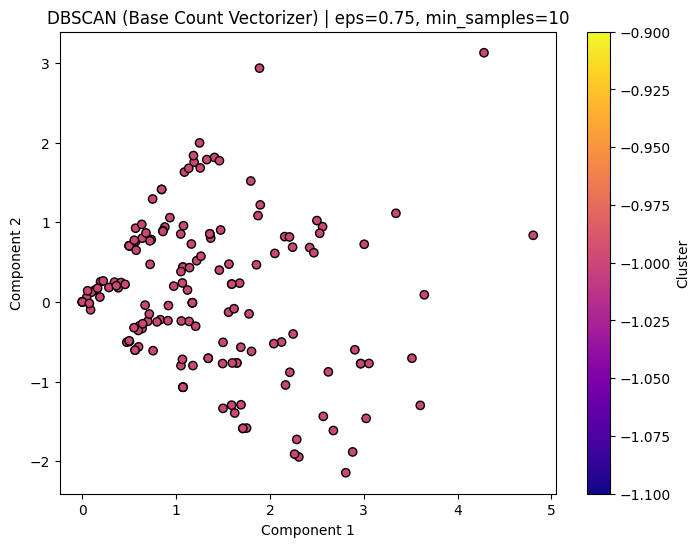

Results for Stops TFIDF Vectorizer | eps=0.75, min_samples=10

Cluster Counts:
 cluster_label
-1    144
 0     18
Name: count, dtype: int64 

--- Cluster -1 ---
                                                                  lemmatized_text  \
0                                       help leftbehind community make a comeback   
1                                           partial revocation of executive order   
2      advance united states leadership in artificial intelligence infrastructure   
3                     take additional step with respect to the situation in syria   
4  provide for the appointment of alumnus of americorp to the competitive service   

   cluster_label  
0             -1  
1             -1  
2             -1  
3             -1  
4             -1   

--- Cluster 0 ---
                                                               lemmatized_text  \
19    combat emerge firearm threat and improve schoolbased activeshooter drill   
25                            

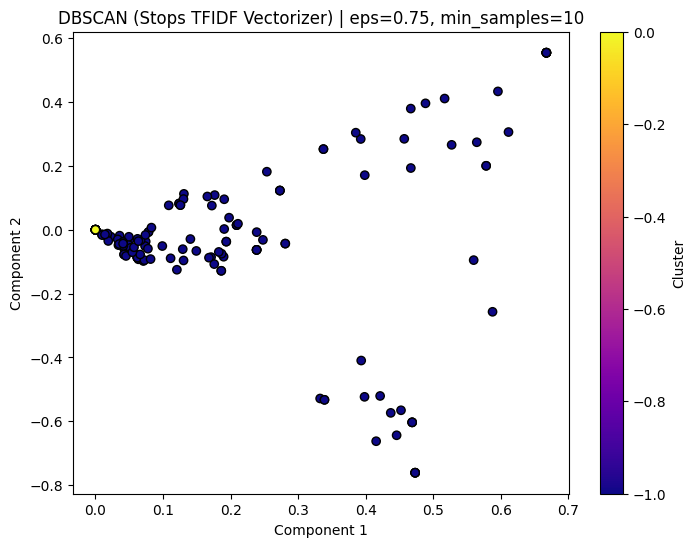

Results for Max Features TFIDF Vectorizer | eps=0.75, min_samples=10

Cluster Counts:
 cluster_label
-1    98
 0    32
 1    18
 2    14
Name: count, dtype: int64 

--- Cluster -1 ---
                                                                   lemmatized_text  \
1                                            partial revocation of executive order   
3                      take additional step with respect to the situation in syria   
4   provide for the appointment of alumnus of americorp to the competitive service   
5                    strengthen and promote innovation in the nation cybersecurity   
6  provide an order of succession within the office of the national cyber director   

   cluster_label  
1             -1  
3             -1  
4             -1  
5             -1  
6             -1   

--- Cluster 0 ---
                                                                                                                                                                     

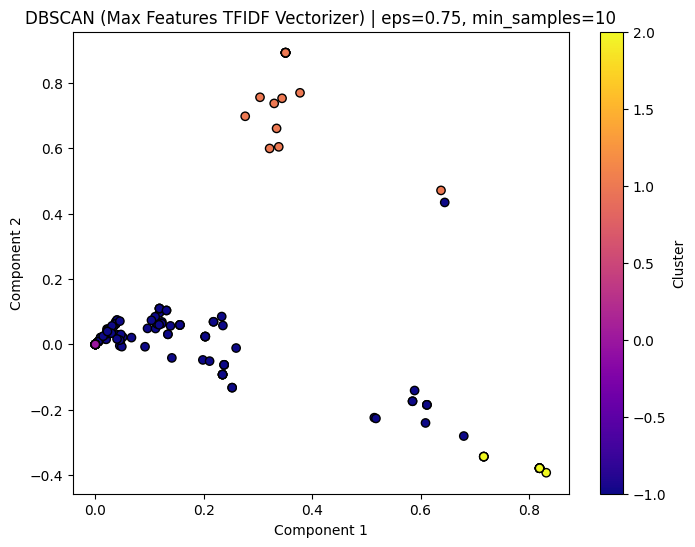

In [ ]:
# Loop through saved DBSCAN results
for result in dbscan_results:
    vectorizer_name = result["vectorizer_name"]
    eps = result["eps"]
    min_samples = result["min_samples"]
    dbscan_labels = result["dbscan_labels"]
    lemmatized_texts = result["lemmatized_text"]
    X = result["vectorized_data"]

    # Create a DataFrame with cluster labels
    results_df = pd.DataFrame({
        "lemmatized_text": lemmatized_texts,
        "cluster_label": dbscan_labels
    })

    # Display cluster counts and details
    print(f"Results for {vectorizer_name} | eps={eps}, min_samples={min_samples}\n")
    print("Cluster Counts:\n", results_df['cluster_label'].value_counts(), "\n")

    for cluster_id in sorted(results_df['cluster_label'].unique()):
        print(f"--- Cluster {cluster_id} ---")
        cluster_points = results_df[results_df['cluster_label'] == cluster_id]
        print(cluster_points.head(5)[['lemmatized_text', 'cluster_label']], "\n")

    # Reduce dimensionality for visualization
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(X)

    # Plot the clusters
    plt.figure(figsize=(8, 6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=dbscan_labels, cmap='plasma', marker='o', edgecolor='k')
    plt.title(f"DBSCAN ({vectorizer_name}) | eps={eps}, min_samples={min_samples}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(label="Cluster")
    plt.show()

# **Conclusion:**

This was my first time playing around with DBScan so I know I need to do a bit more experimental design to better understand how to maximize it's potential. Further experiments will focus on max features, min doc frequency, as well as eps and minimum_samples; additionally, with a base idea for the number of clusters for the titles, a supplemental implementation of Kmeans will also help solidify the groups.

In [1]:
%%shell
jupyter nbconvert --to html /content/Nikita_Ramsey_WK3_HW.ipynb

[NbConvertApp] Converting notebook /content/Nikita_Ramsey_WK3_HW.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 9 image(s).
[NbConvertApp] Writing 1488550 bytes to /content/Nikita_Ramsey_WK3_HW.html
